# 03 - Main Pipeline (Registro de 3 imágenes)

**Introducción:**
En este notebook aplicaremos la lógica desarrollada en los diferentes módulos creados en la carpeta src. Esta lógica es la misma que se utilizó en el archivo 02_synthetic_validation.ipynb PAra el registro de imagenes; la diferencia radica en que aquí estará separada y optimizada por módulos.

Posteriormente, utilizaremos dimensiones conocidas para establecer una escala métrica que nos permita estimar las dimensiones de otros objetos en la imagen registrada.


In [1]:
# Estandar
import sys, os, math
from pathlib import Path
import inspect
import json
from typing import List, Tuple

# Terceros
import cv2, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from PIL import Image

# Locales
sys.path.append(str(Path.cwd().parent)) # Añadir el directorio padre al path
from src.feature_detection import detect_and_describe
from src.matching import flann_match, bf_match, ratio_test_filter
from src.registration import stitch_three_images, find_homography_ransac
from src.measurement import compute_scale_from_reference, interactive_measurement, pixels_distance
from src.utils import read_img, draw_keypoints

print('Modules imported')


Modules imported


# Primera parte
----------------------------------------------------------------------------

Procedemos a realizar el registro sobre las imagenes del comedor suministradas previamente por el profesor.

## Registro de Imagenes

Shapes: (869, 1159, 3) (869, 652, 3) (869, 652, 3)


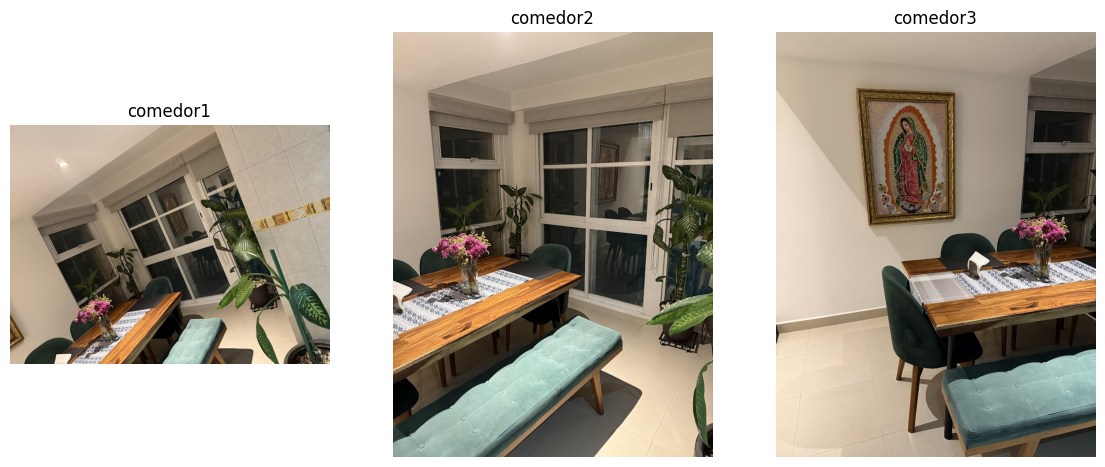

In [2]:
# Cargar las 3 imágenes (BGR) desde data/original
img1 = read_img('../data/original/comedor1.jpg')
img2 = read_img('../data/original/comedor2.jpg')
img3 = read_img('../data/original/comedor3.jpg')
print('Shapes:', img1.shape, img2.shape, img3.shape)
plt.figure(figsize=(14,6))
plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)); plt.title('comedor1'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)); plt.title('comedor2'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(cv2.cvtColor(img3,cv2.COLOR_BGR2RGB)); plt.title('comedor3'); plt.axis('off')
plt.show()


## Detección y visualización de keypoints (ejemplo con SIFT/ORB)


Keypoints imagen 1: 2942
Keypoints imagen 2: 1319
Keypoints imagen 3: 1147


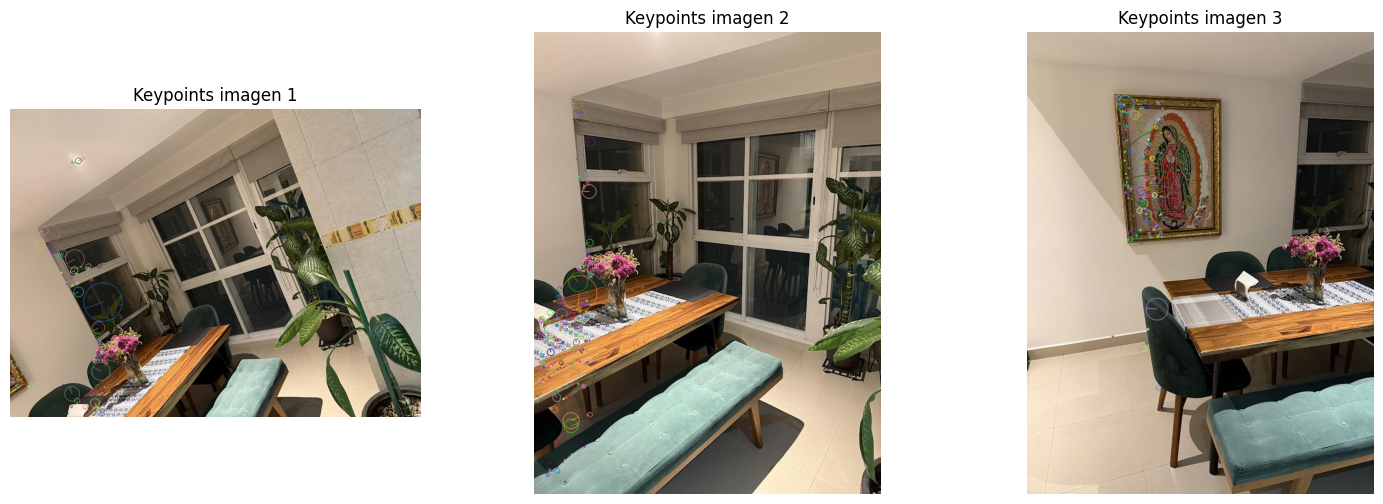

In [3]:
# Detectar keypoints en las tres imágenes con fallback automático
def detect_safe(img, method='SIFT'):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    try:
        kp, des = detect_and_describe(gray, method=method)
    except Exception as e:
        print('Falling back to ORB due to:', e)
        kp, des = detect_and_describe(gray, method='ORB')
    return kp, des

# Lista de imágenes
images = [img1, img2, img3]

# Detectar keypoints y descriptores
results = []
kimgs = []
for i, img in enumerate(images, start=1):
    kp, des = detect_safe(img, method='SIFT')
    results.append((kp, des))
    print(f'Keypoints imagen {i}: {len(kp)}')
    kimgs.append(draw_keypoints(img, kp, max_kpts=200))

# Mostrar las tres imágenes juntas
plt.figure(figsize=(18, 6))
for i, kimg in enumerate(kimgs, start=1):
    plt.subplot(1, 3, i)
    plt.imshow(cv2.cvtColor(kimg, cv2.COLOR_BGR2RGB))
    plt.title(f'Keypoints imagen {i}')
    plt.axis('off')
plt.show()

# Si quieres acceder luego a los keypoints y descriptores:
kp1, des1 = results[0]
kp2, des2 = results[1]
kp3, des3 = results[2]


## Matching y estimación de matrices de homografía

Procedemos en primer instancia a encontrar coincidencia entre los siguientes pares de imagenes:
- comedor1.jpg y comedor2.jpg
- comedor1.jpg y comedor3.jpg

Finalmente usando RANSAC hallamos las respectivas matrices de homografía.


Good matches 1-2: 441 Good matches 1-3: 225


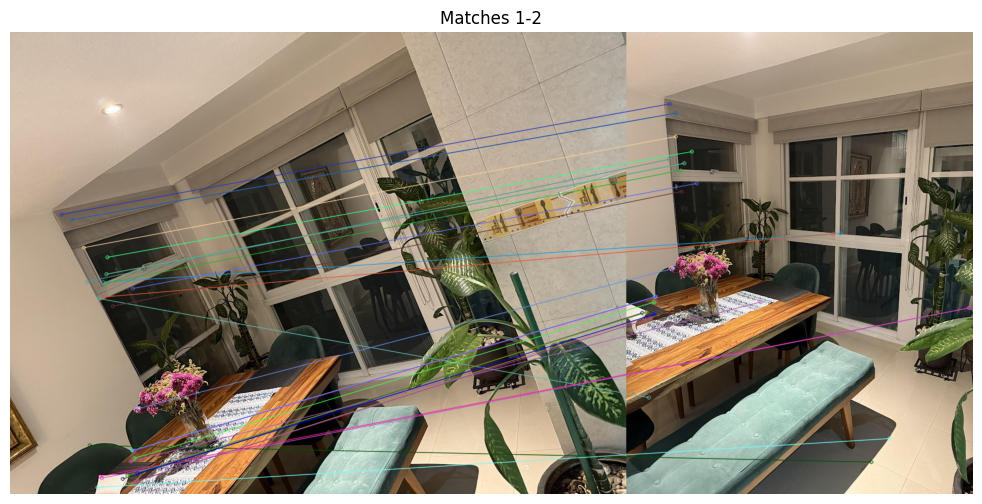

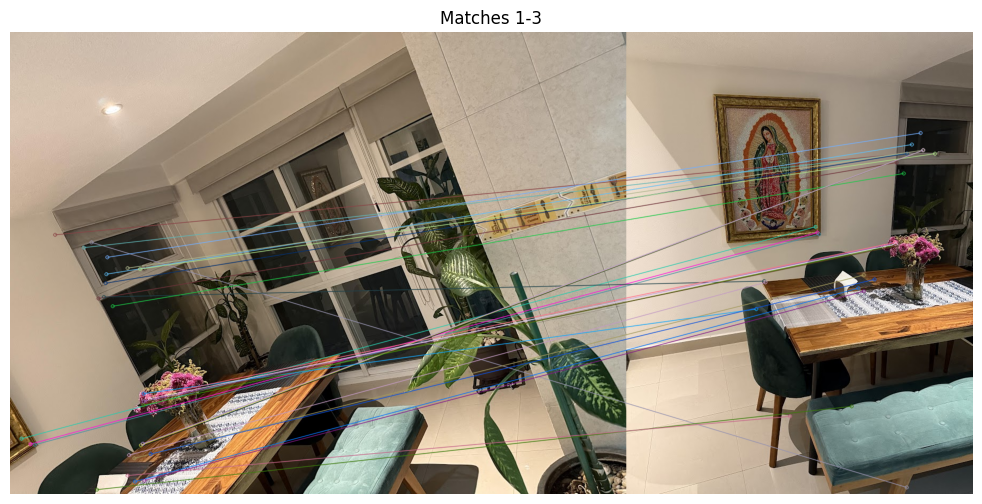

In [4]:
# Perform matching 1<->2 and 1<->3 using FLANN (with fallback)
def match_safe(d1, d2):
    """ try FLANN matcher, fallback to BFMatcher """
    try:
        matches_knn = flann_match(d1, d2, k=2)
    except Exception as e:
        print('FLANN failed, fallback to BFMatcher:', e)
        matches_knn = bf_match(d1, d2)
    return matches_knn

m12 = match_safe(des1, des2)
m13 = match_safe(des1, des3)
good12 = ratio_test_filter(m12, ratio=0.75)
good13 = ratio_test_filter(m13, ratio=0.75)
print('Good matches 1-2:', len(good12), 'Good matches 1-3:', len(good13))
# Visualize top matches
img_m12 = cv2.drawMatches(img1, kp1, img2, kp2, good12[:30], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img_m13 = cv2.drawMatches(img1, kp1, img3, kp3, good13[:30], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(14,6)); plt.imshow(cv2.cvtColor(img_m12, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.title('Matches 1-2'); plt.show()
plt.figure(figsize=(14,6)); plt.imshow(cv2.cvtColor(img_m13, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.title('Matches 1-3'); plt.show()


In [5]:
# Estimar homografías usando RANSAC
H12, mask12 = find_homography_ransac(kp1, kp2, good12, ransac_thresh=5.0) if len(good12) >=4 else (None,None)
H13, mask13 = find_homography_ransac(kp1, kp3, good13, ransac_thresh=5.0) if len(good13) >=4 else (None,None)
print('H12 is None?', H12 is None, 'H13 is None?', H13 is None)
if H12 is not None:
    print('H12 first row:', H12[0])
    print('H12 second row:', H12[1])
    print('H12 third row:', H12[2])
print("\n--------------------//--------------------\n")
if H13 is not None:
    print('H13 first row:', H13[0])
    print('H13 second row:', H13[1])
    print('H13 third row:', H13[2])


H12 is None? False H13 is None? False
H12 first row: [  1.24591463   0.46217404 -56.96602112]
H12 second row: [ -0.56620938   1.34836194 181.42919654]
H12 third row: [1.59918465e-05 8.42295886e-05 1.00000000e+00]

--------------------//--------------------

H13 first row: [ 2.61004933e+00  1.23508505e+00 -1.31726330e+03]
H13 second row: [-9.14096073e-02  2.11881380e+00  4.86205649e+02]
H13 third row: [ 1.77440732e-03 -6.59542923e-05  1.00000000e+00]


In [6]:
""" Realizamos una inspección rápida de la función detect_and_describe."""
print("repr:", repr(detect_and_describe))
print("type:", type(detect_and_describe))
try:
    print("signature:", inspect.signature(detect_and_describe))
except Exception as e:
    print("no signature:", e)
print("callable?:", callable(detect_and_describe))

repr: <function detect_and_describe at 0x000001DA7F041760>
type: <class 'function'>
signature: (img: numpy.ndarray, method: str = 'SIFT') -> Tuple[List[cv2.KeyPoint], numpy.ndarray]
callable?: True


## Registro completo de las 3 imágenes


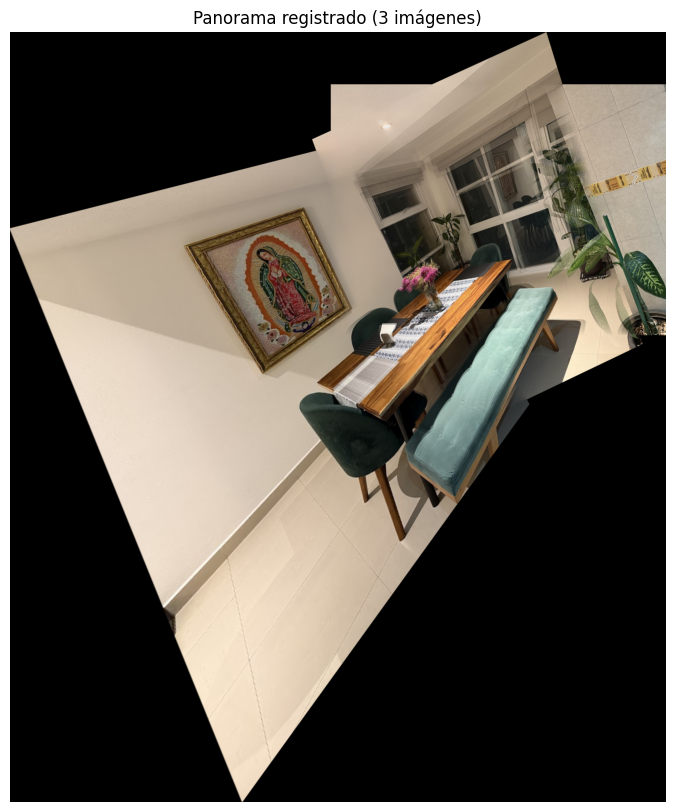

Panorama guardado en results/figures/panorama_registered_complete.png


In [7]:
# Use the improved stitch_three_images para generar panorama y despues guardarlo
try:
    pano, Hs = stitch_three_images(img1, img2, img3, detector_fn=detect_and_describe, matcher_fn=flann_match, method='SIFT', ratio=0.75)
    pano_rgb = cv2.cvtColor(pano, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(16,10)); plt.imshow(pano_rgb); plt.axis('off'); plt.title('Panorama registrado (3 imágenes)'); plt.show()
    os.makedirs('../results/figures', exist_ok=True)
    cv2.imwrite('../results/figures/panorama_registered_complete.png', pano)
    print('Panorama guardado en results/figures/panorama_registered_complete.png')
except Exception as e:
    print('Error durante el cosido:', e)
    print('Si falla, intente cambiar method="ORB" en el llamado.')


# Segunda parte 
----------------------------------------------------------------------------

Procedemos a realizar una calibracion con metricas conocidas sobre objetos en la imagen, para luego estimar de forma interactiva más objetos en la imagen registrada

## Calibración de métricas

- Cuadro (altura: 117 cm)
- La mesa (ancho: 161.1 cm)


## Coordenadas de referencia

A continuación, realizamos una de selección de puntos de forma interactiva en la imagen 'panorama_registered_complete.png'.
Al ejecutar la siguiente celda, se mostrará la imagen en una ventana emergente.
La idea es seleccionar cuatro puntos haciendo clic en los siguientes lugares:
- Esquina superior izquierda del cuadro.
- Esquina inferior izquierda del cuadro.
- Extremo inferior izquierdo de la mesa.
- Extremo inferior derecho de la mesa.

Al realizar esta selección permitiremos ajustar una calibracion interna en la imagen con la información ya conocida del cuadro y la mesa

Instrucciones: clic en 4 puntos en el siguiente orden:
 1) Esquina superior izquierda del cuadro
 2) Esquina inferior izquierda del cuadro
 3) Extremo inferior izquierdo de la mesa
 4) Extremo inferior derecho de la mesa


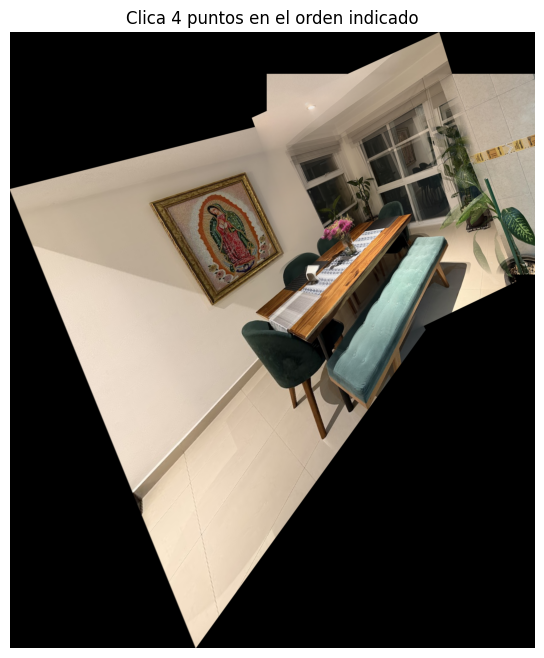

No se recibieron 4 clics vía matplotlib. Intentando fallback con OpenCV (ventana nativa)...
Picture top, bottom: (611, 736) (872, 1148)
Table left, right: (1068, 1207) (1302, 1323)


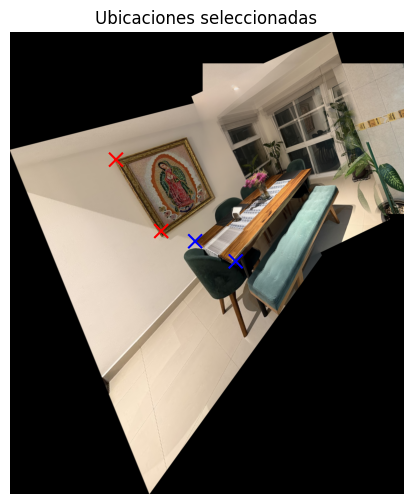

Saved coords.json


In [8]:
# Selección interactiva de puntos en la imagen registrada 'panorama_registered_complete.png'
img_path = '../results/figures/panorama_registered_complete.png'
base = Image.open(img_path)
img_arr = np.array(base)

print("Instrucciones: clic en 4 puntos en el siguiente orden:")
print(" 1) Esquina superior izquierda del cuadro")
print(" 2) Esquina inferior izquierda del cuadro")
print(" 3) Extremo inferior izquierdo de la mesa")
print(" 4) Extremo inferior derecho de la mesa")

def select_points_mpl(img, n_points=4, title='Clica los puntos'):
    """Intento interactivo con matplotlib + mpl_connect."""
    pts = []
    fig, ax = plt.subplots(figsize=(12,8))
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

    # Callback para registrar clics
    def onclick(event):
        if event.xdata is None or event.ydata is None:
            return
        x, y = int(round(event.xdata)), int(round(event.ydata))
        pts.append((x, y))
        ax.plot(x, y, 'rx', markersize=12)
        fig.canvas.draw()
        # Si ya hay suficientes puntos, desconectar evento
        if len(pts) >= n_points:
            fig.canvas.mpl_disconnect(cid)
            plt.close(fig)

    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    plt.show()
    return pts

def select_points_cv2(img, n_points=4, title='Selecciona puntos (ESC para cancelar)', max_margin_px=100):
    """
    Fallback usando ventana OpenCV y callback de ratón.
    Escala la imagen para que quepa en pantalla (preservando aspect ratio) y
    convierte las coordenadas de los clics en coordenadas de la imagen original.
    """
    import math
    pts = []

    # Obtener tamaño original
    orig_h, orig_w = img.shape[:2]

    # Intentar obtener tamaño de pantalla con tkinter; si falla usar fallback
    try:
        from tkinter import Tk
        root = Tk()
        root.withdraw()
        screen_w = root.winfo_screenwidth()
        screen_h = root.winfo_screenheight()
        root.destroy()
        # dejar un margen para decoraciones de ventana
        max_w = max(200, screen_w - max_margin_px)
        max_h = max(200, screen_h - max_margin_px)
    except Exception:
        # fallback razonable para notebooks / entornos sin tkinter
        max_w, max_h = 1200, 800

    # calcular factor de escala (<= 1)
    scale = min(1.0, max_w / orig_w, max_h / orig_h)

    # preparar imagen a mostrar (BGR para cv2)
    vis_orig = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2BGR)
    if scale < 1.0:
        disp_w, disp_h = int(round(orig_w * scale)), int(round(orig_h * scale))
        vis = cv2.resize(vis_orig, (disp_w, disp_h), interpolation=cv2.INTER_AREA)
    else:
        disp_w, disp_h = orig_w, orig_h
        vis = vis_orig.copy()

    window = 'Select points - ' + title

    # copia para dibujar marcadores sin alterar la imagen base
    vis_draw = vis.copy()

    def mouse_cb(event, x, y, flags, param):
        nonlocal vis_draw
        if event == cv2.EVENT_LBUTTONDOWN:
            # convertir coordenada de ventana a coordenada original
            orig_x = int(round(x / scale))
            orig_y = int(round(y / scale))
            pts.append((orig_x, orig_y))

            # dibujar marcador en la imagen mostrada (en coordenadas de la imagen escalada)
            cv2.drawMarker(vis_draw, (x, y), (0, 0, 255), markerType=cv2.MARKER_CROSS, markerSize=20, thickness=2)
            # mostrar índice del punto
            idx = len(pts)
            cv2.putText(vis_draw, str(idx), (max(0, x+8), max(0, y-8)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2, cv2.LINE_AA)
            cv2.imshow(window, vis_draw)

    # Crear ventana redimensionable
    cv2.namedWindow(window, cv2.WINDOW_NORMAL)
    # opcion: establecer tamaño inicial igual a la de la imagen escalada
    cv2.resizeWindow(window, disp_w, disp_h)
    cv2.setMouseCallback(window, mouse_cb)
    cv2.imshow(window, vis_draw)

    # Esperar hasta que el usuario marque n_points o presione ESC
    while True:
        key = cv2.waitKey(1) & 0xFF
        # si se alcanzaron los puntos o ESC (27) -> salir
        if len(pts) >= n_points or key == 27:
            break
        # si se cierra la ventana por el gestor de ventanas -> salir
        try:
            if cv2.getWindowProperty(window, cv2.WND_PROP_VISIBLE) < 1:
                break
        except Exception:
            # algunos backends pueden lanzar si la ventana ya no existe
            break

    cv2.destroyWindow(window)
    # devolver coordenadas en la escala original
    return pts

# Primero intentar método matplotlib (funciona en Jupyter clásico con backend interactivo o con ipympl)
points = []
try:
    # Intento interativo con matplolib
    points = select_points_mpl(img_arr, n_points=4, title='Clica 4 puntos en el orden indicado')
except Exception as e:
    print("Error con matplotlib interactivo:", e)

if len(points) < 4:
    print("No se recibieron 4 clics vía matplotlib. Intentando fallback con OpenCV (ventana nativa)...")
    try:
        points = select_points_cv2(img_arr, n_points=4)
    except Exception as e:
        print("Fallback OpenCV falló:", e)

# Si aún no hay 4 puntos, usar valores por defecto
if len(points) < 4:
    print("Selección interactiva falló o incompleta; usando valores por defecto aproximados.")
    # Estas coordenadas salen de una ejecución previa
    picture_top = (670, 733)
    picture_bottom = (973, 1139)
    table_left = (1181, 1192)
    table_right = (1396, 1285)
    
else:
    picture_top, picture_bottom, table_left, table_right = points[0], points[1], points[2], points[3]

print('Picture top, bottom:', picture_top, picture_bottom)
print('Table left, right:', table_left, table_right)

# Mostrar ubicación en la imagen base con los puntos escogidos
plt.figure(figsize=(10,6))
plt.imshow(img_arr)
plt.scatter([picture_top[0], picture_bottom[0]],[picture_top[1], picture_bottom[1]], c=['r','r'], s=100, marker='x')
plt.scatter([table_left[0], table_right[0]],[table_left[1], table_right[1]], c=['b','b'], s=100, marker='x')
plt.title('Ubicaciones seleccionadas')
plt.axis('off')
plt.show()

# Guardar coordenadas
coords = {'picture_top': picture_top, 'picture_bottom': picture_bottom,
          'table_left': table_left, 'table_right': table_right}
with open('../results/measurements/coords.json','w') as f:
    json.dump(coords, f)
print('Saved coords.json')


## Medición de un objeto en el panorama

Ahora dado que conocemos que coordenadas satisfacen las mediciones proporcinadas, procedemos a calibrar los pixeles para realizar mas mediciones


In [9]:
# Carga coords.json y calcula escala con incertidumbre
coords_path = Path('../results/measurements/coords.json')
with coords_path.open('r') as f:
    coords = json.load(f)

pt = tuple(coords['picture_top'])
pb = tuple(coords['picture_bottom'])
tl = tuple(coords['table_left'])
tr = tuple(coords['table_right'])

# Parámetros que puedes ajustar:
real_picture_height_m = 1.17   # 117 cm -> 1.17 m (referencia conocida)
sigma_real_m = 0.01            # incertidumbre de la medida real (m). Ajusta (ej. 0.01 = 1 cm)
sigma_pixel = 0.5              # incertidumbre de localización en pixeles (±0.5 px típico)

# Usando las funciones importadas de measurement.py
pixel_height = pixels_distance(pt, pb)  # distancia en píxeles usando la función importada
meters_per_pixel = compute_scale_from_reference(pixel_height, real_picture_height_m)

# incertidumbre por propagación (scale = real / pixel)
# d(scale)/scale = sqrt( (d_real/real)^2 + (d_pixel/pixel)^2 )
sigma_scale = meters_per_pixel * math.sqrt((sigma_real_m/real_picture_height_m)**2 + (sigma_pixel / max(1.0, pixel_height))**2)

print(f'pixel_height (picture): {pixel_height:.1f} px')
print(f'meters_per_pixel = {meters_per_pixel:.6f} m/px ± {sigma_scale:.6f} m/px (1σ)')

pixel_height (picture): 487.7 px
meters_per_pixel = 0.002399 m/px ± 0.000021 m/px (1σ)


In [10]:
# Ancho del cuadro y largo de la mesa (usando coords.json guardadas)
# Para el cuadro (asumimos top y bottom definen altura).

# mesa: distancia entre table_left y table_right (ancho en pixeles y metros)
px_table = pixels_distance(tl, tr)
table_length_m = px_table * meters_per_pixel

# incertidumbre en la distancia en metros:
# sigma_d^2 = (px * sigma_scale)^2 + (scale * sigma_px_dist)^2
sigma_px_dist = sigma_pixel * math.sqrt(2)  # dos coordenadas contributivas aprox.
sigma_table_m = math.sqrt((px_table * sigma_scale)**2 + (meters_per_pixel * sigma_px_dist)**2)
print(f'Mesa (ancho reference): {px_table:.1f} px -> {table_length_m:.3f} m ± {sigma_table_m:.3f} m (1σ)')

# cuadro: si guardaste la izquierda/derecha del cuadro, mide igual; si no,
# estimación desde pixels de alto:
picture_height_m = pixel_height * meters_per_pixel
sigma_picture_m = math.sqrt((pixel_height * sigma_scale)**2 + (meters_per_pixel * sigma_pixel)**2)
print(f'Cuadro (altura reference): {pixel_height:.1f} px -> {picture_height_m:.3f} m ± {sigma_picture_m:.3f} m (1σ)')


Mesa (ancho reference): 261.2 px -> 0.627 m ± 0.006 m (1σ)
Cuadro (altura reference): 487.7 px -> 1.170 m ± 0.010 m (1σ)


In [11]:
# Comparación usando las funciones del módulo measurement.py

# 1. Calcular escala usando la función importada compute_scale_from_reference
pixel_height_alt = pixels_distance(pt, pb)  # usando la función importada
meters_per_pixel_alt = compute_scale_from_reference(pixel_height_alt, real_picture_height_m)
print(f'Escala calculada con compute_scale_from_reference: {meters_per_pixel_alt:.6f} m/px')
print(f'Comparación con cálculo manual: {abs(meters_per_pixel - meters_per_pixel_alt):.9f} m/px de diferencia')

# 2. Demostración de medición interactiva individual
print("\nEjemplo de uso de interactive_measurement para una medida:")
print("1. La imagen se mostrará en una ventana")
print("2. Haz clic en dos puntos para medir la distancia")
print("3. La distancia se mostrará en metros\n")

# Cargar la imagen registrada
img_path = '../results/figures/panorama_registered_complete.png'
img_for_measure = cv2.imread(img_path)
if img_for_measure is not None:
    print("Para hacer una medición individual, ejecuta:")
    print("interactive_measurement(img_for_measure, meters_per_pixel)")
    print("\nNota: Esta función es más simple que interactive_measurements_cv2,")
    print("      útil para mediciones rápidas individuales.")

Escala calculada con compute_scale_from_reference: 0.002399 m/px
Comparación con cálculo manual: 0.000000000 m/px de diferencia

Ejemplo de uso de interactive_measurement para una medida:
1. La imagen se mostrará en una ventana
2. Haz clic en dos puntos para medir la distancia
3. La distancia se mostrará en metros

Para hacer una medición individual, ejecuta:
interactive_measurement(img_for_measure, meters_per_pixel)

Nota: Esta función es más simple que interactive_measurements_cv2,
      útil para mediciones rápidas individuales.


# Mediciones de forma interactiva

Al ejecutar la siguiente celda, aparecerá la imagen registrada en una ventana emergente con el objetivo de que usted realice mediciones dentro de la imagen mediante pares de clics.

In [12]:
# Medidas interactivas con OpenCV (ventana externa)

def interactive_measurements_cv2(img_rgb: np.ndarray,
                                 meters_per_pixel: float,
                                 n_pairs: int = 3,
                                 window_name: str = 'measure') -> List[Tuple[float, float, Tuple[int,int], Tuple[int,int]]]:
    """
    Interactivo con OpenCV:
      - Click izquierdo: añadir punto (pares: inicio->fin)
      - 'q' : terminar y cerrar
      - 'u' : deshacer último punto / par
      - 'r' : reiniciar todo
    Devuelve lista de tuples: (px_dist, meters, p1, p2)
    Nota: img_rgb debe ser formato RGB (p.ej. desde PIL / matplotlib). 
    """
    # Convertir RGB -> BGR para OpenCV
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    canvas = img_bgr.copy()
    pts: List[Tuple[int,int]] = []
    measurements: List[Tuple[float, float, Tuple[int,int], Tuple[int,int]]] = []

    FONT = cv2.FONT_HERSHEY_SIMPLEX

    def redraw():
        # Redibuja el canvas desde el original usando pts
        nonlocal canvas, img_bgr, measurements
        canvas = img_bgr.copy()
        # dibujar todos los puntos y pares actuales
        for i, p in enumerate(pts):
            cv2.circle(canvas, p, 4, (0,0,255), -1)  # rojo puntos
        # dibujar pares y textos
        measurements = []
        for i in range(1, len(pts), 2):
            p1 = pts[i-1]; p2 = pts[i]
            px = ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)**0.5
            m = px * meters_per_pixel
            measurements.append((px, m, p1, p2))
            cv2.line(canvas, p1, p2, (255,0,0), 2)  # azul linea
            mx, my = (p1[0]+p2[0])//2, (p1[1]+p2[1])//2
            text = f'{m:.3f} m'
            # fondo para legibilidad
            (tw, th), _ = cv2.getTextSize(text, FONT, 0.6, 2)
            cv2.rectangle(canvas, (mx-4, my-th-4), (mx+tw+4, my+4), (255,255,255), -1)
            cv2.putText(canvas, text, (mx, my), FONT, 0.6, (0,0,0), 2, cv2.LINE_AA)

    # Mouse callback
    def on_mouse(event, x, y, flags, param):
        nonlocal pts
        if event == cv2.EVENT_LBUTTONDOWN:
            # añadir punto (int)
            pts.append((int(x), int(y)))
            redraw()
            cv2.imshow(window_name, canvas)

    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.imshow(window_name, canvas)
    cv2.setMouseCallback(window_name, on_mouse)

    help_msg = ("Instrucciones: click izquierdo para puntos (pares). "
                "q = salir, u = deshacer, r = reiniciar.")
    print(help_msg)

    # Loop principal: chequear teclas
    while True:
        cv2.imshow(window_name, canvas)
        key = cv2.waitKey(20) & 0xFF
        if key == ord('q'):
            break
        elif key == ord('u'):
            # deshacer último punto (o último par si ya hay par incompleto)
            if pts:
                pts.pop()
                redraw()
                cv2.imshow(window_name, canvas)
            else:
                print("Nada que deshacer.")
        elif key == ord('r'):
            pts = []
            redraw()
            cv2.imshow(window_name, canvas)
        # si ya alcanzamos n_pairs completos salimos automáticamente
        if len(pts) // 2 >= n_pairs:
            print(f"Alcanzado n_pairs = {n_pairs}. Cerrando...")
            break

    cv2.destroyAllWindows()
    # recalcular y devolver medidas finales (por si hubo cambios)
    final_measurements = []
    for i in range(1, len(pts), 2):
        p1 = pts[i-1]; p2 = pts[i]
        px = ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)**0.5
        m = px * meters_per_pixel
        final_measurements.append((px, m, p1, p2))

    print(f"Mediciones obtenidas: {len(final_measurements)} pares.")
    for j, (px, m, p1, p2) in enumerate(final_measurements, 1):
        print(f"{j}: px={px:.2f}, m={m:.4f}, p1={p1}, p2={p2}")

    return final_measurements

img = np.array(Image.open('../results/figures/panorama_registered_complete.png').convert('RGB'))
meters_per_pixel = 0.0025   # ejemplo: ajustar según tu escala
meas = interactive_measurements_cv2(img, meters_per_pixel, n_pairs=3)
meas


Instrucciones: click izquierdo para puntos (pares). q = salir, u = deshacer, r = reiniciar.
Alcanzado n_pairs = 3. Cerrando...
Mediciones obtenidas: 3 pares.
1: px=721.57, m=1.8039, p1=(1523, 1533), p2=(1873, 902)
2: px=435.49, m=1.0887, p1=(775, 1947), p2=(1152, 1729)
3: px=479.27, m=1.1982, p1=(1781, 322), p2=(1901, 786)


[(721.5684305732894, 1.8039210764332236, (1523, 1533), (1873, 902)),
 (435.4916761546654, 1.0887291903866636, (775, 1947), (1152, 1729)),
 (479.2661056240051, 1.1981652640600127, (1781, 322), (1901, 786))]

In [13]:
# Convertir mediciones a DataFrame, calcular incertidumbre por medición y guardar
def measurement_uncertainty(px_dist, meters_per_pixel, sigma_scale, sigma_pixel=0.5):
    sigma_px_dist = sigma_pixel * math.sqrt(2)  # aproximación
    sigma_m = math.sqrt((px_dist * sigma_scale)**2 + (meters_per_pixel * sigma_px_dist)**2)
    return sigma_m

rows = []
for i,(px,m,p1,p2) in enumerate(meas):
    sigma_m = measurement_uncertainty(px, meters_per_pixel, sigma_scale, sigma_pixel)
    rows.append({
        'id': i+1,
        'px_dist': px,
        'meters': m,
        'sigma_m': sigma_m,
        'p1': p1,
        'p2': p2
    })

df_meas = pd.DataFrame(rows)
display(df_meas)
# guardar
out_path = Path('../results/measurements/measurements.json')
with out_path.open('w') as f:
    json.dump({'scale_m_per_px': meters_per_pixel, 'scale_sigma': sigma_scale,
               'measurements':[r for r in rows]}, f, default=str)
print('Guardado en', out_path)


id     px_dist    meters   sigma_m            p1            p2
0   1  721.568431  1.803921  0.015005  (1523, 1533)   (1873, 902)
1   2  435.491676  1.088729  0.009165   (775, 1947)  (1152, 1729)
2   3  479.266106  1.198165  0.010054   (1781, 322)   (1901, 786)

Guardado en ..\results\measurements\measurements.json


# Estimaciones automáticas
Si ya tienes puntos guardados o si quieres medir puntos "conocidos".

- Supón que tienes coords para (ventana_left, ventana_right), (silla_a, silla_b) etc. Aquí damos un formato para que puedas rellenar con tus puntos medidos si los tienes.

In [14]:
extra_items = {
    'cuadro_altura_px': pixel_height,  # ya conocida
    'cuadro_ancho_px': None,
    'mesa_largo_px': px_table, # ya conocida
    # si mediste con interactive_measurements, puedes copiar px desde df_meas
}

# convertir lo que exista
results = {}
if extra_items['cuadro_altura_px'] is not None:
    px = extra_items['cuadro_altura_px']
    results['cuadro_altura_m'] = (px * meters_per_pixel, measurement_uncertainty(px, meters_per_pixel, sigma_scale, sigma_pixel))
if extra_items['cuadro_ancho_px'] is not None:
    px = extra_items['cuadro_ancho_px']
    results['cuadro_ancho_m'] = (px * meters_per_pixel, measurement_uncertainty(px, meters_per_pixel, sigma_scale, sigma_pixel))
if extra_items['mesa_largo_px'] is not None:
    px = extra_items['mesa_largo_px']
    results['mesa_largo_m'] = (px * meters_per_pixel, measurement_uncertainty(px, meters_per_pixel, sigma_scale, sigma_pixel))

results


{'cuadro_altura_m': (np.float64(1.2192851389236237), 0.010225641117209298),
 'mesa_largo_m': (np.float64(0.6529356783022352), 0.005675768981459893)}

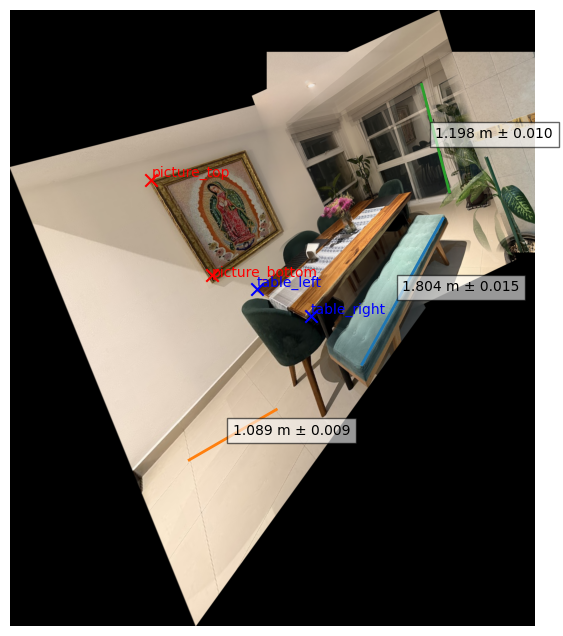

Overlay guardado en ../results/figures/measurements_overlay.png


In [15]:
# Mostrar imagen con anotaciones guardadas (coords + mediciones interactivas)

fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(img); ax.axis('off')
# puntos de referencia (cuadro y mesa)
ax.scatter([pt[0], pb[0]],[pt[1], pb[1]], c='r', s=80, marker='x')
ax.scatter([tl[0], tr[0]],[tl[1], tr[1]], c='b', s=80, marker='x')
ax.text(pt[0], pt[1]-15, 'picture_top', color='r')
ax.text(pb[0], pb[1]+5, 'picture_bottom', color='r')
ax.text(tl[0], tl[1]-10, 'table_left', color='b')
ax.text(tr[0], tr[1]-10, 'table_right', color='b')

# anotaciones de mediciones interactivas si existen
for row in rows:
    p1, p2 = row['p1'], row['p2']
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], lw=2)
    ax.text((p1[0]+p2[0])/2, (p1[1]+p2[1])/2, f"{row['meters']:.3f} m ± {row['sigma_m']:.3f}", bbox=dict(facecolor='white', alpha=0.6))
plt.show()

# opcional: guardar figura
fig.savefig('../results/figures/measurements_overlay.png', dpi=200, bbox_inches='tight')
print('Overlay guardado en ../results/figures/measurements_overlay.png')


# Conclusiones

- El pipeline principal logra registrar las tres imágenes del comedor en un panorama utilizable para calibración métrica; la combinación de detección, matching y RANSAC produce homografías razonables si hay suficientes matches fiables.

- La calibración y las funciones de medición integradas (`compute_scale_from_reference`, `interactive_measurement`) permiten convertir píxeles a metros y estimar incertidumbres; lo cual nos permite obtener mas informacion de la imagen, por ejemplo conocer que tan grande es la ventana.